In [0]:
import numpy as np
import pandas as pd
from joblib import dump, load

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import QuantileTransformer, MinMaxScaler

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import QuantileTransformer

import matplotlib.pyplot as plt
import seaborn as sns

# Preview Data

In [2]:
df = pd.read_csv("fish_participant.csv")
df.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340
1,Perch,110.0,20.0,22.0,23.5,5.5225,3.9950
2,Roach,160.0,20.5,22.5,25.3,7.0334,3.8203
3,Parkki,60.0,14.3,15.5,17.4,6.5772,2.3142
4,Bream,700.0,30.4,33.0,38.3,14.8604,5.2854


## Check Data types

In [3]:
print(df.dtypes)

Species     object
Weight     float64
Length1    float64
Length2    float64
Length3    float64
Height     float64
Width      float64
dtype: object


## Check Nulls

In [4]:
df.isnull().sum()

Species    0
Weight     0
Length1    0
Length2    0
Length3    0
Height     0
Width      0
dtype: int64

## Functions

In [0]:
# Check Linear Distribution
def plot_linear(df, cols): 
  X = df[cols]

  g = sns.PairGrid(df, y_vars=["Weight"], x_vars=cols, height=4)
  g.map(sns.regplot)

# Plot Normal Distribution
def plot_normal(df):
  fig, axs = plt.subplots(2, 3, figsize=(20, 10))

  sns.kdeplot(df["Weight"].values, shade=True, ax=axs[0,0])
  sns.kdeplot(df["Length1"].values, shade=True, ax=axs[0,1])
  sns.kdeplot(df["Length2"].values, shade=True, ax=axs[0,2])
  sns.kdeplot(df["Length3"].values, shade=True, ax=axs[1,0])
  sns.kdeplot(df["Height"].values, shade=True, ax=axs[1,1])
  sns.kdeplot(df["Width"].values, shade=True, ax=axs[1,2])

def remove_outliers(df):
	np.seterr(divide='ignore', invalid='ignore')
	cols = ["Length1", "Length2", "Length3", "Height", "Width"]	
	# Add and id based on the df's index
	df["id"]= df.index
	species = df.Species.unique()

	# Loop through features
	for col in cols:		
		# Column to sum adjusted values from all column_specie
		df[col + "_ro"] = 0

		# Loop through species
		for specie in species:
			X = df.loc[df["Species"] == specie]
			X = X[["id", "Species", col]]
			# Calculate mean by specie
			df_mean = df.groupby(["Species"])[col].mean()
			X = X.merge(df_mean, how="left", on="Species", suffixes=("", "_mean_" + specie))

			# Identify outlier by feature and specie
			X[col + "_outl_" + specie] = IsolationForest(contamination="auto").fit_predict(X[[col]])

			# Replace outliers with mean by feature and specie 
			X[col + "_ro_" + specie] = np.where(X[col + "_outl_" + specie] == 1, X[col], X[col + "_mean_" + specie])
			X = X[["id", col + "_ro_" + specie]]
			df = df.merge(X, how="left", on="id")

			# Combine adjusted columns by feature
			df[col + "_ro_" + specie] = df[col + "_ro_" + specie].fillna(0)
			df[col + "_ro"] = df[col + "_ro"] + df[col + "_ro_" + specie]
			df = df.drop(col + "_ro_" + specie, axis=1)

	return df

# Add calculated features
def add_features(df):

	# Air density
	p = 1.225

	# Calculate Max length
	df = df.assign(Lmax=df[["Length1_ro", "Length2_ro", "Length3_ro"]].min(axis=1))

	# Calculate Average length
	df = df.assign(Lavg=df[["Length1_ro", "Length2_ro", "Length3_ro"]].mean(axis=1))
	
	# Calculate Mass
	df = df.assign(Mass=p * df["Height_ro"] * df["Width_ro"] * df["Lmax"])

	# # Calculate Volume
	df = df.assign(Volume=df["Height_ro"] * df["Width_ro"] * df["Lmax"])

	# Round all columns
	df = df.round(decimals=3)

	return df

# Normalize and Scale features
def normalize(df, features):
	for col in features:
		X = df.iloc[:, df.columns == col]

		# Normalize feature by quantiles
		X_trans = QuantileTransformer(n_quantiles=20, output_distribution='normal').fit_transform(X)
		df[col + "_QT"] = X_trans

		# Scale normalized feature to its original range
		X_trans = MinMaxScaler(feature_range=(X[col].min(), X[col].max())).fit_transform(X_trans)
		df[col + "_MMS"] = X_trans

		# Clean dataframe
		df = df[df.columns.drop(list(df.filter(regex='_QT')))]
	return df

## Raw Data Linearity

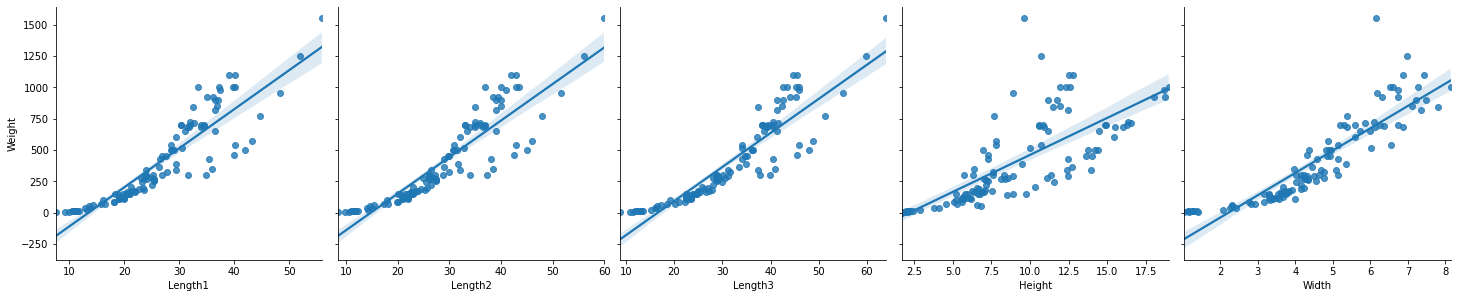

In [6]:
cols = ["Length1", "Length2", "Length3","Height", "Width"]
plot_linear(df, cols)

## Raw Data Distribution

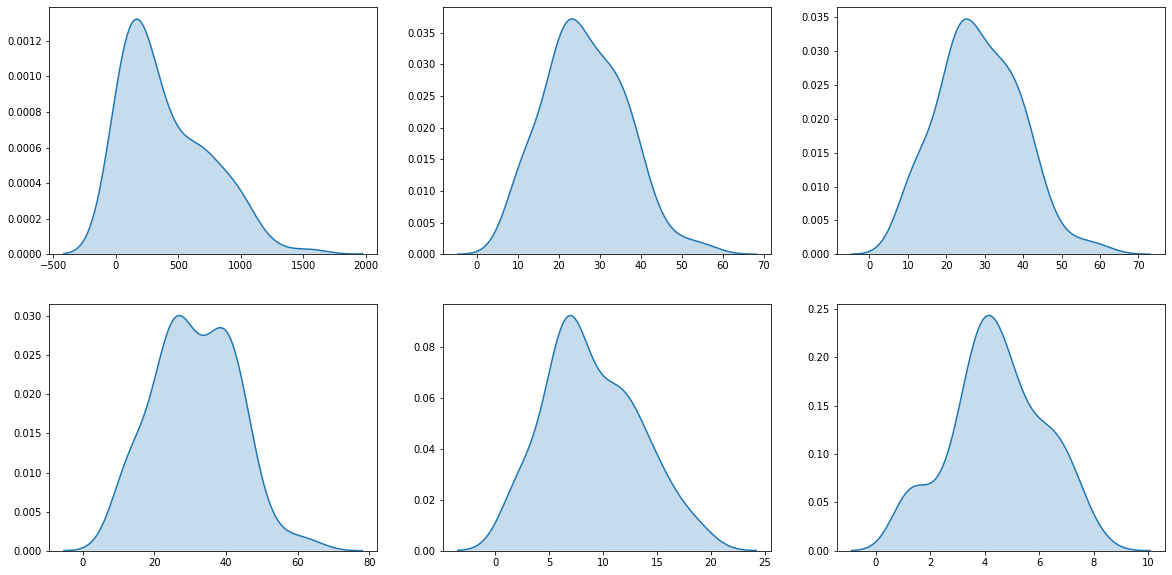

In [7]:
plot_normal(df)

## Remove Outliers (Isolation Forest)

In [8]:
df = remove_outliers(df)
df.head()

,Species,Weight,Length1,Length2,Length3,Height,Width,id,Length1_ro,Length2_ro,Length3_ro,Height_ro,Width_ro
0,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340,0,26.50,29.0,34.0,12.444000,5.134000
1,Perch,110.0,20.0,22.0,23.5,5.5225,3.9950,1,20.00,22.0,23.5,5.522500,3.995000
2,Roach,160.0,20.5,22.5,25.3,7.0334,3.8203,2,20.50,22.5,25.3,7.033400,3.820300
3,Parkki,60.0,14.3,15.5,17.4,6.5772,2.3142,3,19.15,20.8,23.3,9.174162,3.303325
4,Bream,700.0,30.4,33.0,38.3,14.8604,5.2854,4,30.40,33.0,38.3,14.860400,5.285400


## Add Calculated Features

In [9]:
df= add_features(df)
df.head()

,Species,Weight,Length1,Length2,Length3,Height,Width,id,Length1_ro,Length2_ro,Length3_ro,Height_ro,Width_ro,Lmax,Lavg,Mass,Volume
0,Bream,430.0,26.5,29.0,34.0,12.444,5.134,0,26.50,29.0,34.0,12.444,5.134,26.50,29.833,2073.948,1693.019
1,Perch,110.0,20.0,22.0,23.5,5.522,3.995,1,20.00,22.0,23.5,5.522,3.995,20.00,21.833,540.528,441.248
2,Roach,160.0,20.5,22.5,25.3,7.033,3.820,2,20.50,22.5,25.3,7.033,3.820,20.50,22.767,674.765,550.829
3,Parkki,60.0,14.3,15.5,17.4,6.577,2.314,3,19.15,20.8,23.3,9.174,3.303,19.15,21.083,710.923,580.345
4,Bream,700.0,30.4,33.0,38.3,14.860,5.285,4,30.40,33.0,38.3,14.860,5.285,30.40,33.900,2924.947,2387.712


## Feature Correlation and Selection (>74%)

In [10]:
cor = df.corr()
cor_target = abs(cor["Weight"])
relevant_features = cor_target[cor_target>0.74]
print(relevant_features)

Weight      1.000000
Length1     0.900963
Length2     0.904090
Length3     0.909553
Width       0.893368
Width_ro    0.742513
Mass        0.752575
Volume      0.752575
Name: Weight, dtype: float64


## Normalize Data

In [14]:
cols = ["Length1", "Length2", "Length3", "Width_ro"]

df = normalize(df, cols)
df.head()

,Species,Weight,Length1,Length2,Length3,Height,Width,id,Length1_ro,Length2_ro,Length3_ro,Height_ro,Width_ro,Lmax,Lavg,Mass,Volume,Length1_MMS,Length2_MMS,Length3_MMS,Width_MMS,Width_ro_MMS,Length1_ro_MMS,Length2_ro_MMS,Length3_ro_MMS
0,Bream,430.0,26.5,29.0,34.0,12.444,5.134,0,26.50,29.0,34.0,12.444,5.134,26.50,29.833,2073.948,1693.019,32.145590,34.674528,37.353620,4.914205,4.690365,27.578531,30.239128,32.632032
1,Perch,110.0,20.0,22.0,23.5,5.522,3.995,1,20.00,22.0,23.5,5.522,3.995,20.00,21.833,540.528,441.248,28.794668,31.055770,32.736909,4.389597,4.111752,24.938304,26.637129,27.805316
2,Roach,160.0,20.5,22.5,25.3,7.033,3.820,2,20.50,22.5,25.3,7.033,3.820,20.50,22.767,674.765,550.829,29.192513,31.652032,34.007284,4.314729,4.041150,25.503847,27.245417,29.320743
3,Parkki,60.0,14.3,15.5,17.4,6.577,2.314,3,19.15,20.8,23.3,9.174,3.303,19.15,21.083,710.923,580.345,26.228899,28.300330,30.175428,3.746030,3.677333,24.307228,25.806348,27.579835
4,Bream,700.0,30.4,33.0,38.3,14.860,5.285,4,30.40,33.0,38.3,14.860,5.285,30.40,33.900,2924.947,2387.712,33.616805,36.218235,38.919148,4.953647,4.741945,29.889500,31.914900,34.464046


## Linearity after Normalization

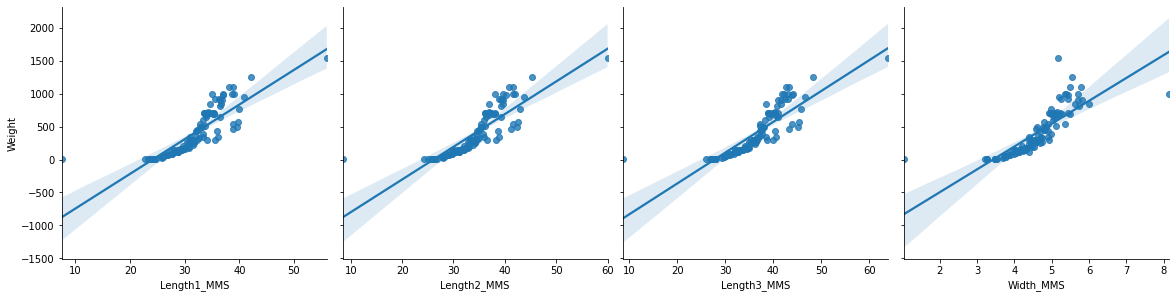

In [19]:
cols = ["Length1_MMS", "Length2_MMS", "Length3_MMS", "Width_MMS"]
plot_linear(df, cols)

## Distribution after Normalization (i.e. raw Lenght2 v. final Lenght2)

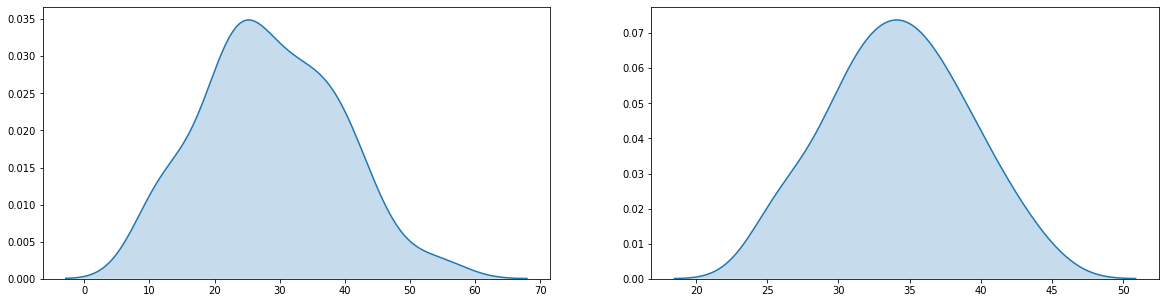

In [23]:
df = df.iloc[:, df.columns != "Species"]
df = df.apply(lambda x: x.clip(lower=x.quantile(0.01),upper=x.quantile(0.99)))
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
sns.kdeplot(df["Length2"].values, shade=True, ax=axs[0])
sns.kdeplot(df["Length2_MMS"].values, shade=True, ax=axs[1])

## Model Training
Train Size: 76%

Test Size: 33%

Model Accuracy: 99.85%

Model Strategy: ExtraTreeRegressor

## Predictions
mse: 39.83